Parent Directory: ../test/
H-tune: 6.33, H-Chroma: -0.507
V-Tune: 6.3, V-Chroma: -0.246

PFW settings: 
  k1prpfwf: 0.00024
  k1prpfwd: -0.000404
  k2prpfwf: 0.010274
  k2prpfwd: -0.020515
Matching took 18.32 seconds
Converting sequence "ps": 99%     
generating ./0f2a9335bfb247a1bca56b8194e33b5f.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'
Dispersion at seh23: 2.662809784448017
Dispersion at smh57: 6.093465633523801


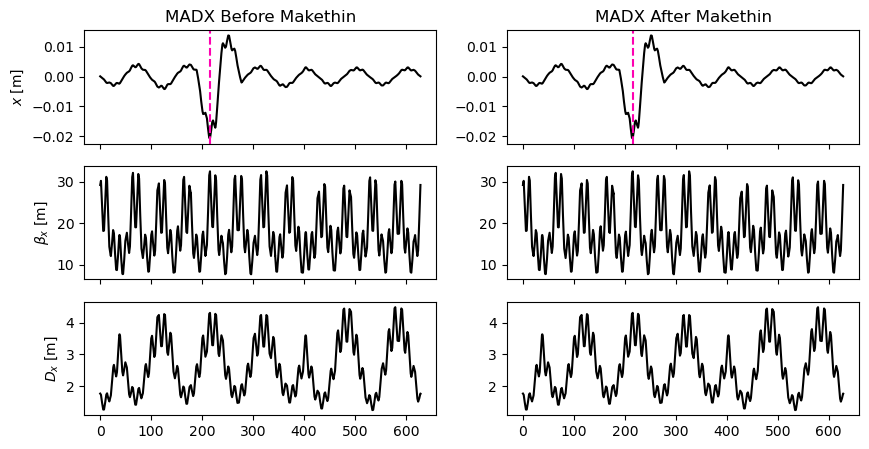

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np
import pandas as pd

from cpymad.madx import Madx

import scipy as sp

from tqdm import tqdm
import time

from signal_gen import generate_chirp_signal
import os

part = int(100)

N_PART = part

RAD_TO_MRAD = 1000
M_TO_MM = 1000

REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

# p = 24 # beam momentum (GeV/c)
# momentum = 24 # beam momentum (GeV/c)
p = 5.392
momentum = p
Brho = p*3.3356

PS_radius = 70.079
DPP_FACTOR = 1e-3

## QUAD COLLAPSE

TUNE_TARGET = 0.330
#TUNE_TARGET = 1/3
CHROMATICITY_TARGET = -0.5
N_TURN = int( 5e2 )

DETUNE_QUAD_KNL1 = -0.04
# DETUNE_QUAD_KNL1 = 0

## rifko

SEPTA = True
EXCITER_SAMPLING_FREQ = 1e6

CHIRP_START = .3
CHIRP_STOP = .35

CHIRP_INTERVAL = 1 / 1000 # seconds

SEPTA_X_MM = -68.8

RFKO_STRENGTH = .5

PARENT_DIR = "../test/"

os.makedirs(PARENT_DIR, exist_ok=True)

print(f"Parent Directory: {PARENT_DIR}")
mad = Madx(stdout=False)

PS_REPO = "../../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")

# turn off 23 for ions
mad.input("kPEBSW23 := 0;")

mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=False,stderr=False)
        madx.option(verbose=False, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',
                    pc=p,
                    ex=ex,
                    ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
    ptc_create_universe;
    ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
    IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
    }
    ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
    }
    ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict
time_before = time.time()
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=TUNE_TARGET,Qxp=CHROMATICITY_TARGET,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 
time_after = time.time()
print(f"Matching took {round(time_after-time_before,2)} seconds")

mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

##### INITIAL ##

twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.command.install(element = 'marker_seh23', class_='MARKER', at=-0.4, from_='PE.SEH23')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")

initial_conditions = (-0.07, (-0.00135 + -0.0015)/2)
# mad.input('kpebsw57 = 0.0;')
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_cycled_beta = mad.twiss(x=initial_conditions[0], px=initial_conditions[1], beta0="bumped23").dframe()
##### CYCLED ##
twiss_cycled = mad.twiss().dframe()

twiss_before_makethin = mad.twiss().dframe()

# Makethin
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

twiss_after_makethin = mad.twiss().dframe()

# Convert to Xtrack
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(),
    )
#line = bare_line.filter_elements(exclude_types_starting_with='Cavity')
fig, ax = plt.subplots(3, 2, figsize = (10, 5), sharex=True)

madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]

ax[0, 0].plot(twiss_before_makethin.s, twiss_before_makethin.x, 'k', label='MADX')
ax[0, 1].plot(twiss_after_makethin.s, twiss_after_makethin.x, 'k', label='MADX')

ax[1, 0].plot(twiss_before_makethin.s, twiss_before_makethin.betx, 'k', label='MADX')
ax[1, 1].plot(twiss_after_makethin.s, twiss_after_makethin.betx, 'k', label='MADX')

ax[2, 0].plot(twiss_before_makethin.s, twiss_before_makethin.dx, 'k', label='MADX')
ax[2, 1].plot(twiss_after_makethin.s, twiss_after_makethin.dx, 'k', label='MADX')


ax[0, 0].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')
ax[0, 1].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')

ax[0, 0].set_title("MADX Before Makethin")
ax[0, 1].set_title("MADX After Makethin")

ax[0, 0].set_ylabel(r"$x$ [m]")
ax[1, 0].set_ylabel(r"$\beta_x$ [m]")
ax[2, 0].set_ylabel(r"$D_x$ [m]")

fig.savefig(f"{PARENT_DIR}/twiss_comparison.png")


detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

ctx = xo.ContextCpu()

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)
tracker = line.build_tracker()
co_guess = line.build_particles(
    x = initial_conditions[0],
    px = initial_conditions[1],
)
tw = tracker.twiss(method='4d')

print(f"Dispersion at seh23: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'seh23' in n][0]]}")
print(f"Dispersion at smh57: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'smh57' in n][0]]}")
FREV = 1/tw['T_rev']

x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

(x_in_sigmas, px_in_sigmas, _, _) = xp.generate_2D_uniform_circular_sector(
    num_particles = N_PART,
    r_range = (0.5, 1.5),
    theta_range = (0, 2*np.pi)
)

Need second attempt on closed orbit search


Text(0, 0.5, 'px [rad]')

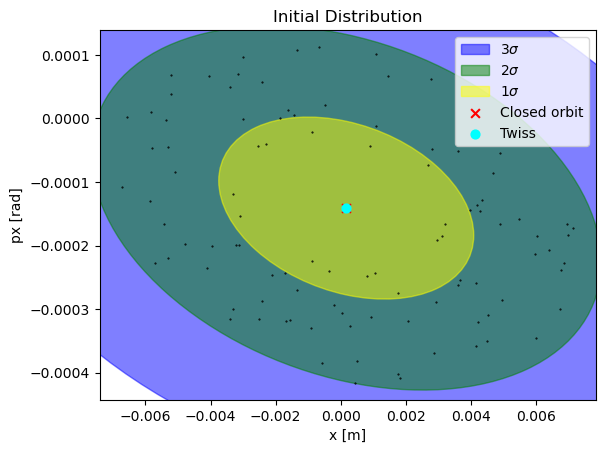

In [3]:

particles = line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)

cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='o', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')



In [4]:


fig.savefig(f"{PARENT_DIR}/initial_distribution.png")

line.unfreeze()

septum = xt.LimitRect(
    min_x = SEPTA_X_MM*0.001, # in meters
)
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)
tracker = line.build_tracker()

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

# Track
tunes = []
strengths = []
print(f"Tracking for {N_TURN} turns for detuning")


generating ./b774d5646d3c490eb30b5afcd87805b9.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'
Tracking for 500 turns for detuning


In [5]:
twtwtw = tracker.twiss(method='4d')

In [8]:
twtwtw['T_rev']

2.4233187777173852e-06

In [4]:

# QUAD COLLAPSE
delta = line['DETUNING_QUAD'].knl[1]/N_TURN
time_before = time.time()
for turn in tqdm(range(N_TURN)):
    # Detuning
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])

time_after = time.time()
print(f"Detune took {round(time_after-time_before, 2)} seconds")
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = tracker.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")


pregenerated_particles_pandas = particles.to_pandas()
pregenerated_particles_pandas.to_hdf(f"{PARENT_DIR}/pregenerated_particles.hdf", mode="w", key="pregenerated_particles_pandas")



100%|██████████| 500/500 [10:05<00:00,  1.21s/it]


Detune took 605.97 seconds
Tune before detune: 6.243640355407018
Tune after detune: 6.328553891601296


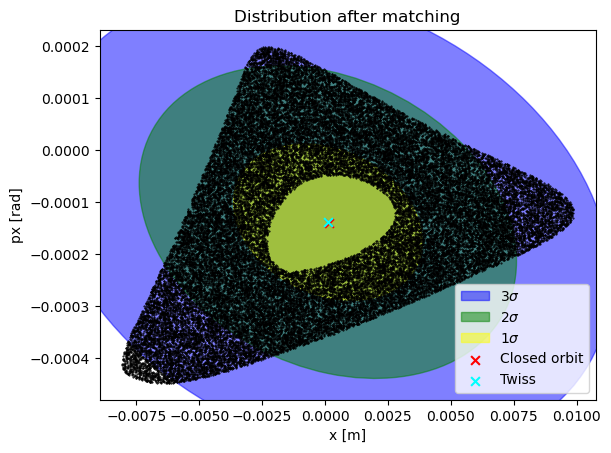

In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Distribution after matching")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')

fig.savefig(f"{PARENT_DIR}/final_distribution.png")


In [6]:

def run_rfko(
    interval = 1,
    chirp_start = .3,
    chirp_stop = .35,
    chirp_reps = int( 500 ),
    gain = 0.1,
    parts_file = "pregenerated_particles.hdf",
    chirp_lasts_for_turns = 256,
):
    ctx = xo.ContextCpu()
    #ctx = xo.ContextPyopencl()

    CHIRP_INTERVAL = interval / 1000        # interval between chirps (s)  
    CHIRP_START = chirp_start               # start freq of chirp (tune)
    CHIRP_STOP = chirp_stop                 # stop freq of chirp (tune)
    CHIRP_REPETITIONS = chirp_reps          # number of chirps
    GAIN = gain                             # gain of the exciter
    if CHIRP_INTERVAL*1000 % 1 == 0:
        DIR = PARENT_DIR + f"gain_{gain}/{int(CHIRP_INTERVAL*1000)}"
    else:
        DIR = PARENT_DIR + f"gain_{gain}/{round(float(CHIRP_INTERVAL*1000), 3)}"
    try:
        os.makedirs(DIR)
    except FileExistsError:
        print("Run exists, skipped")
        return
    print(f"Run Directory: {DIR}")

    # Generate Line
    mad.use(sequence="PS")
    line = xt.Line.from_madx_sequence(
        mad.sequence(),
    )
    line.particle_ref = xp.Particles(
        mass0=xp.PROTON_MASS_EV,
        q0=1,
        p0c=p*sp.constants.c
    )

    # Generate Signal
    chirp_time, chirp_signal, chirp_turns = generate_chirp_signal(
            sampling_freq = EXCITER_SAMPLING_FREQ,
            chirp_start_freq = CHIRP_START*FREV,
            chirp_stop_freq = CHIRP_STOP*FREV,
            chirp_rep_time = CHIRP_INTERVAL,
            turn_freq=FREV,
            chirp_repetitions = CHIRP_REPETITIONS,
            chirp_turns = chirp_lasts_for_turns
        )

    N_TURN_CHIRP = int(chirp_turns)
    print(f"Num Turns: {N_TURN_CHIRP}")

    # Add Elements
    septum = xt.LimitRect(
        min_x = SEPTA_X_MM*0.001, # in meters
    )
    line.insert_element(
        element = septum,
        name = "SEPTUM",
        index = 'pe.smh57'
    )
    
    from scipy import constants
    def kick_angle(gain=.1):
        c = constants.c # m/s, speed of light
        E0 = 0.93827e9 # eV, proton rest energy
        mu0 = 4*np.pi*(10**-7) # H/m, vacuum permeability

        T = 2e9 # eV, proton KE
        P = 5e3 # W, TFB peak power / electrode
        Z = 100 # Ohm, TFB impedance / electrode

        L = 935e-3 # m, TFB length
        r = 70e-3 # m, TFB separation

        E = T + E0 # Total Energy
        gamma = E / E0 # Normalized energy (lorentz)
        beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
        cp = np.sqrt(E**2 - E0**2) # eV, particle momentum

        # Electric Field
        Vp = np.sqrt(P * Z * 2) # peak voltage
        V = Vp * gain
        Efield = V / r # adjusted for gain

        # Magnetic Field
        I = np.sqrt((V**2/Z)/Z*2) # current
        Hfield = (2*I) / (2*np.pi*r) # adjusted for gain
        Bfield = Hfield * mu0

        # Angle
        theta_M = c/1e9*Bfield*L / (cp/10**9)
        theta_E = Efield/1e9*L / (cp/10**9 * beta)
        theta = theta_E + theta_M
        return theta

    rfko_kick = kick_angle(GAIN)

    rfko_exciter = xt.Exciter(
        _context = ctx,
        samples = chirp_signal,
        sampling_frequency = EXCITER_SAMPLING_FREQ,
        frev = FREV,
        start_turn = 0,
        knl = [rfko_kick]
    )
    line.insert_element(
        element = rfko_exciter,
        name = f'EXCITER',
        index = 'pr.kfb97'
    )

    # open particles
    particles = xp.Particles.from_pandas(pd.read_hdf(f"{PARENT_DIR}/{parts_file}", key="pregenerated_particles_pandas"), _context=ctx)

    time_before = time.time()
    rfko_line = line.build_tracker(_context=ctx)

    for turn in tqdm(range(N_TURN_CHIRP)):
        rfko_line.track(particles, num_turns = 1)
    #rfko_line.track(particles, num_turns = int(chirp_turns))
    loss_list = list(zip(particles.at_turn, zip(particles.x, particles.px)))
    time_after = time.time()
    print(f"RFKO took {round(time_after-time_before, 2)} seconds")

    # fig, ax = plt.subplots()
    # import colors
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable


    cts_dict = dict(zip(*np.unique(particles.at_turn, return_counts=True)))
    turn_counts = []
    turn_culm = []
    for trn in range(N_TURN_CHIRP+N_TURN):
        try:
            turn_counts.append(cts_dict[trn])
            turn_culm.append(turn_culm[-1] + cts_dict[trn])
        except KeyError:
            turn_counts.append(0)
            try:
                turn_culm.append(turn_culm[-1])
            except IndexError:
                turn_culm.append(0)
    from collections import Counter
    counter_turns, counter_counts = list(zip(*sorted(Counter(particles.at_turn).items())))
    counter_turns = np.array(counter_turns)
    counter_counts = np.array(counter_counts)
    counter_culm = np.cumsum(counter_counts)

    ######################################################################################

    fig, ax = plt.subplots(figsize=(16, 6))
    ax_instant = ax.twinx()
    ax_culm = ax.twinx()

    try:
        ax.plot(chirp_time, chirp_signal[:len(chirp_time)], label='Chirp', color='blue', alpha=.1)
    except ValueError:
        ax.plot(chirp_time[:len(chirp_signal)], chirp_signal, label='Chirp', color='blue', alpha=.1)
    ax_instant.plot(np.array(range(N_TURN+N_TURN_CHIRP))*1/FREV, turn_counts, 'k-', zorder=1)
    ax_culm.plot(np.array(range(N_TURN+N_TURN_CHIRP))*1/FREV, turn_culm, 'r-', zorder=1)

    ax.set_ylim(0, max(chirp_signal[:-1]))
    ax_instant.set_ylim(0, max(turn_counts))
    ax_instant.set_ylabel("Particle loss [cts./turn]")
    ax_culm.set_ylim(0, max(turn_culm))
    ax_culm.set_ylabel("Cumulative loss [cts.]")

    ax.set_yticklabels([])
    ax.tick_params(axis='y',left=False, right=False,labelleft=False, labelright=False)
    ax_instant.yaxis.tick_left()
    ax_instant.yaxis.set_label_position("left")

    ax.set_xlabel("Time [s]")


    # ax.set_xlabel("Turn")
    # ax.set_ylabel("Particles lost per turn", color='k')
    # ax2.set_ylabel("Cumulative particles lost", color='k')

    # set title
    ax.set_title("Particle Losses")
    fig.savefig(f"{DIR}/EXTRACTION.png")

    ######################################################################################


    from collections import Counter
    counter_turns, counter_counts = list(zip(*sorted(Counter(particles.at_turn).items())))
    counter_turns = np.array(counter_turns)
    counter_counts = np.array(counter_counts)
    counter_culm = np.cumsum(counter_counts)

    # Save Particles
    import pickle as pkl
    # Particles
    particles.to_pandas().to_parquet(f"{DIR}/particles.parquet")

    with open(f"{DIR}/loss_locations.pkl", "wb") as f:
        pkl.dump(loss_list, f)
    with open(f"{DIR}/extraction.pkl", "wb") as f:
        pkl.dump(np.array(list(zip(*sorted(Counter(particles.at_turn).items())))), f)
    # Sequence
    mad.save(sequence = 'ps', file = f"{DIR}/sequence.seq")
    constant_dict = {
        "distribution":
            {
                "rel_gamma": REL_GAMMA,
                "rel_beta": REL_BETA,
                "exn": exn,
                "eyn": eyn,
                "ex": ex,
                "ey": ey,
                "p": p,
                "momentum": momentum,
                "Brho": Brho,
                "DPP_FACTOR": DPP_FACTOR,
                "N_PART": N_PART,
            },
        "quad_collapse":
            {
                "TUNE_TARGET": TUNE_TARGET,
                "CHROMATICITY_TARGET": CHROMATICITY_TARGET,
                "N_TURN": N_TURN,
                "DETUNE_QUAD_KNL1": DETUNE_QUAD_KNL1,
            },
        "rfko":
            {
                "SEPTA": SEPTA,
                "EXCITER_SAMPLING_FREQ": EXCITER_SAMPLING_FREQ,
                "FREV": FREV,
                "CHIRP_START": CHIRP_START,
                "CHIRP_STOP": CHIRP_STOP,
                "CHIRP_INTERVAL": CHIRP_INTERVAL,
                "N_TURN_CHIRP": N_TURN_CHIRP,
                "SEPTA_X_MM": SEPTA_X_MM,
                "GAIN": GAIN,
                "CHIRP_REPETITIONS": CHIRP_REPETITIONS
            },
    }
    # save to file
    with open(f"{DIR}/constants.json", "w") as f:
        json.dump(constant_dict, f, indent=4)
    import pickle as pkl
    with open(f"{DIR}/turn_counts_zip.pkl", "wb") as f:
        pkl.dump(list(zip(range(N_TURN+N_TURN_CHIRP), turn_counts)), f)
    with open(f"{DIR}/turn_counts.pkl", "wb") as f:
        pkl.dump(turn_counts, f)

    with open(f"{DIR}/turn_culm_zip.pkl", "wb") as f:
        pkl.dump(list(zip(range(N_TURN+N_TURN_CHIRP), turn_culm)), f)
    with open(f"{DIR}/turn_culm.pkl", "wb") as f:
        pkl.dump(turn_culm, f)

    with open(f"{DIR}/chirp_signal.pkl", "wb") as f:
        pkl.dump(chirp_signal, f)
    with open(f"{DIR}/chirp_time.pkl", "wb") as f:
        pkl.dump(chirp_time, f)

- 10 reps / 4700 turns at 2000 particles: 440 seconds
- 11 reps / 5200 turns at 2000 particles: 233.42 seconds without sleep

# Speedier

In [8]:

# 0,03 is missing 5ms and 10ms
for intvl in [1, 2, 5, 10]:
    for G in [0.05, 0.075, 0.1, 0.15]:
        print("=========== RUNNING RFKO WITH INTERVAL", intvl, "GAIN", G)
        run_rfko(
            interval=intvl,
            chirp_start = .3,
            chirp_stop = .35,
            chirp_reps = int( 20 ),
            gain = G,
            chirp_lasts_for_turns = 256
        )

=========== RUNNING RFKO WITH INTERVAL 1 GAIN 0.05
Run Directory: ../results_hollow/short_run/gain_0.05/1
Converting sequence "ps": 99%     
Num Turns: 8253
generating ./b57a09eef7d94c7d8d6a3a228062dacd.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 8253/8253 [1:20:22<00:00,  1.71it/s]


RFKO took 4826.83 seconds
=========== RUNNING RFKO WITH INTERVAL 1 GAIN 0.075
Run Directory: ../results_hollow/short_run/gain_0.075/1
Converting sequence "ps": 99%     
Num Turns: 8253
generating ./34489fd9256a43f49d5933386c8ffcc1.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 8253/8253 [58:40<00:00,  2.34it/s]  


RFKO took 3523.47 seconds
=========== RUNNING RFKO WITH INTERVAL 1 GAIN 0.1
Run Directory: ../results_hollow/short_run/gain_0.1/1
Converting sequence "ps": 99%     
Num Turns: 8253
generating ./e641af8cea3b4f8a96eda000b34414ea.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 8253/8253 [1:22:35<00:00,  1.67it/s]   


RFKO took 4958.26 seconds
=========== RUNNING RFKO WITH INTERVAL 1 GAIN 0.15
Run Directory: ../results_hollow/short_run/gain_0.15/1
Converting sequence "ps": 99%     
Num Turns: 8253
generating ./b099f0c2def24fc4b0ab8bd1bb7d3ea4.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 8253/8253 [25:09<00:00,  5.47it/s] 


RFKO took 1512.66 seconds
=========== RUNNING RFKO WITH INTERVAL 2 GAIN 0.05
Run Directory: ../results_hollow/short_run/gain_0.05/2
Converting sequence "ps": 99%     
Num Turns: 16506
generating ./ba9792264a764b3cbe50415747aceaff.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 16506/16506 [2:07:44<00:00,  2.15it/s] 


RFKO took 7667.66 seconds
=========== RUNNING RFKO WITH INTERVAL 2 GAIN 0.075
Run Directory: ../results_hollow/short_run/gain_0.075/2
Converting sequence "ps": 99%     
Num Turns: 16506
generating ./71a6ef0965754139bc69407f8f2c3bf4.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 16506/16506 [1:44:01<00:00,  2.64it/s] 


RFKO took 6244.44 seconds
=========== RUNNING RFKO WITH INTERVAL 2 GAIN 0.1
Run Directory: ../results_hollow/short_run/gain_0.1/2
Converting sequence "ps": 99%     
Num Turns: 16506
generating ./6b4c1ff96e294c3489176ad0fb600e87.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 16506/16506 [1:25:15<00:00,  3.23it/s]


RFKO took 5118.7 seconds
=========== RUNNING RFKO WITH INTERVAL 2 GAIN 0.15
Run Directory: ../results_hollow/short_run/gain_0.15/2
Converting sequence "ps": 99%     
Num Turns: 16506
generating ./8b49e6f17eec44e3b5ee7c71362b4f59.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 16506/16506 [58:28<00:00,  4.70it/s] 


RFKO took 3511.88 seconds
=========== RUNNING RFKO WITH INTERVAL 5 GAIN 0.05
Run Directory: ../results_hollow/short_run/gain_0.05/5
Converting sequence "ps": 99%     
Num Turns: 41265
generating ./40106ff059634110bb83d78bdb976117.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 41265/41265 [5:08:39<00:00,  2.23it/s]  


RFKO took 18521.86 seconds
=========== RUNNING RFKO WITH INTERVAL 5 GAIN 0.075
Run Directory: ../results_hollow/short_run/gain_0.075/5
Converting sequence "ps": 99%     
Num Turns: 41265
generating ./5796f65be36f436d886989abc9990b38.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


100%|██████████| 41265/41265 [5:15:19<00:00,  2.18it/s]      


RFKO took 18922.76 seconds
=========== RUNNING RFKO WITH INTERVAL 5 GAIN 0.1
Run Directory: ../results_hollow/short_run/gain_0.1/5
Converting sequence "ps": 99%     
Num Turns: 41265
generating ./4b120fbbf3464fe1b5c654e0f92660ad.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


 43%|████▎     | 17754/41265 [2:11:39<2:33:37,  2.55it/s]

In [ ]:
# 0,03 is missing 5ms and 10ms
for intvl in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for G in [0.05, 0.075, 0.1, 0.125, 0.15]:
        print("=========== RUNNING RFKO WITH INTERVAL", intvl, "GAIN", G)
        run_rfko(
            interval=intvl,
            chirp_start = .3,
            chirp_stop = .35,
            chirp_reps = int( 20 ),
            gain = G,
            chirp_lasts_for_turns = 25
        )

In [ ]:
# THIS GOT UP TO 0.03
for intvl in np.concatenate((np.arange(0.1, 1, 0.4), np.arange(1, 11, 2))):
    for G in np.arange(0.03, 0.16, 0.01):
        print("=========== RUNNING RFKO WITH INTERVAL", intvl, "GAIN", G)
        run_rfko(
            interval=intvl,
            chirp_start = .3,
            chirp_stop = .35,
            chirp_reps = int( 20 ),
            gain = G,
            chirp_lasts_for_turns = 25
        )

# 1 Rep, 2e4 Part

- For Loop, CPU: 178.85 seconds
- NO Loop, CPU: 193.54 seconds

- For Loop, OpenCL: 
- NO Loop, OpenCL: 

In [ ]:
import scipy as sp
from scipy import constants

In [ ]:
constants.c

In [ ]:
madx_smh57_location

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))

madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]
madx_smh61_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh61:1')[0][0]]


ax.plot(twiss_after_makethin['s'], twiss_after_makethin['x']*M_TO_MM, 'k-')
ax.axvline(madx_smh57_location, color='r', linestyle='--')
ax.axvline(madx_smh61_location, color='b', linestyle='--')
ax.set_xlim(100,350)
